# Example tweets

## In-group bio and out-group tweet

In [1]:
# Load tweets, bios, extracted identities
import pandas as pd

fpath = '../output/tweets_bios_identities/virus_v3_2020_4_13.jsonl'
data = pd.read_json(fpath, lines=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408837 entries, 0 to 1408836
Data columns (total 11 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   id_str                1408837 non-null  int64         
 1   created_at            1408837 non-null  datetime64[ns]
 2   user.id_str           1408837 non-null  int64         
 3   user.name             1408837 non-null  object        
 4   user.description      1408837 non-null  object        
 5   text                  1408837 non-null  object        
 6   bio                   1408837 non-null  object        
 7   identities            1408837 non-null  object        
 8   identity_spans        1408837 non-null  object        
 9   tweet_identities      1408837 non-null  object        
 10  tweet_identity_spans  1408837 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 118.2+ MB


In [4]:
# Q2 right-left
right = ['maga', 'patriot', 'patriots', 'republican', 'republicans', 'conservative', 'conservatives']
left = ['liberal', 'liberals', 'democrat', 'democrats', 'socialist', 'socialists', 'leftist', 'leftists']

selected = {}
for combo, name in zip([[right, right], [right, left], [left, left], [left, right]], ['right_right', 'right_left', 'left_left', 'left_right']):
    selected = data[(data.identities.map(lambda identities: any([identity in combo[0] for identity in identities]))) & 
                    (data.tweet_identities.map(lambda identities: any([identity in combo[1] for identity in identities])))]
    samp = selected.sample(50, random_state=9)[['created_at', 'user.description', 'identities', 'text', 'tweet_identities']]
    samp.to_csv(f'../tmp/q2_{name}_examples.csv', index=False)

# Number of users and tweets 
Overall and by period (month, quarter)

In [12]:
# Takes ~16 min
import os
import pandas as pd
from glob import glob
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

dirpath = '../output/tweets_bios_identities/'
tweet_fpaths = sorted(glob(os.path.join(dirpath, '*')))

def select_from_dump(tweet_fpath):
    tweets = pd.read_json(tweet_fpath, lines=True)
    return tweets.drop_duplicates(subset=['id_str'])[['id_str', 'user.id_str', 'created_at']]

dfs = process_map(select_from_dump, tweet_fpaths, max_workers=25, total=len(tweet_fpaths))
len(dfs)

  0%|          | 0/785 [00:00<?, ?it/s]

785

In [13]:
tweets = pd.concat(dfs)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485053009 entries, 0 to 1039509
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id_str       int64         
 1   user.id_str  int64         
 2   created_at   datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 14.5 GB


In [14]:
# Save out for stats
tweets.to_pickle('../tmp/user_tweet_ids_overtime.pkl')

In [15]:
len(tweets['user.id_str'].unique())

17221733

In [16]:
import datetime

tweets2020 = tweets[tweets.created_at < datetime.datetime(2021,1,1)]
tweets2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349084005 entries, 0 to 1039509
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id_str       int64         
 1   user.id_str  int64         
 2   created_at   datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 10.4 GB


In [17]:
len(tweets2020['user.id_str'].unique())

13663557

In [7]:
# Get stats
monthly = tweets.groupby(pd.Grouper(key='created_at', freq='MS')).agg(
    n_tweets=pd.NamedAgg(column="id_str", aggfunc="count"), 
    n_unique_users=pd.NamedAgg(column="user.id_str", aggfunc=lambda x: len(set(x))))
monthly.info()
monthly.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2020-01-01 to 2022-06-01
Freq: MS
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   n_tweets        30 non-null     int64
 1   n_unique_users  30 non-null     int64
dtypes: int64(2)
memory usage: 720.0 bytes


,n_tweets,n_unique_users
created_at,,
2020-01-01,1710781,706925
2020-02-01,13637918,2115615
2020-03-01,41149267,5344798
2020-04-01,42409718,4831125
2020-05-01,42146216,4691446


In [9]:
monthly.to_csv('../output/analysis/monthly_stats.csv')

In [6]:
import pandas as pd
monthly = pd.read_csv('../output/analysis/monthly_stats.csv').set_index('created_at')
monthly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 2020-01-01 to 2022-06-01
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   n_tweets        30 non-null     int64
 1   n_unique_users  30 non-null     int64
dtypes: int64(2)
memory usage: 720.0+ bytes


In [12]:
# Get stats
quarterly = tweets.groupby(pd.Grouper(key='created_at', freq='3MS')).agg(
    n_tweets=pd.NamedAgg(column="id_str", aggfunc="count"), 
    n_unique_users=pd.NamedAgg(column="user.id_str", aggfunc=lambda x: len(set(x))))
quarterly.info()
quarterly

IOStream.flush timed out
IOStream.flush timed out


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10 entries, 2020-01-01 to 2022-04-01
Freq: 3MS
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   n_tweets        10 non-null     int64
 1   n_unique_users  10 non-null     int64
dtypes: int64(2)
memory usage: 240.0 bytes


,n_tweets,n_unique_users
created_at,,
2020-01-01,56497966,5953396
2020-04-01,140075485,8160078
2020-07-01,91317103,6700355
2020-10-01,61193451,5436098
2021-01-01,27083900,3650526
2021-04-01,37019512,3892513
2021-07-01,32919417,3362945
2021-10-01,22371415,2643020
2022-01-01,13903560,2180296


In [13]:
quarterly.to_csv('../output/analysis/quarterly_stats.csv')

## Plots for the paper

In [1]:
import pandas as pd
monthly = pd.read_csv('../output/analysis/monthly_stats.csv', parse_dates=['created_at'])
monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   created_at      30 non-null     datetime64[ns]
 1   n_tweets        30 non-null     int64         
 2   n_unique_users  30 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 852.0 bytes


In [2]:
import datetime

monthly2020 = monthly[monthly.created_at < datetime.datetime(2021,1,1)]
monthly2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   created_at      12 non-null     datetime64[ns]
 1   n_tweets        12 non-null     int64         
 2   n_unique_users  12 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 384.0 bytes


In [6]:
import datetime

selected = monthly[monthly.created_at < datetime.datetime(2022,1,1)]
selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   created_at      24 non-null     datetime64[ns]
 1   n_tweets        24 non-null     int64         
 2   n_unique_users  24 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 768.0 bytes


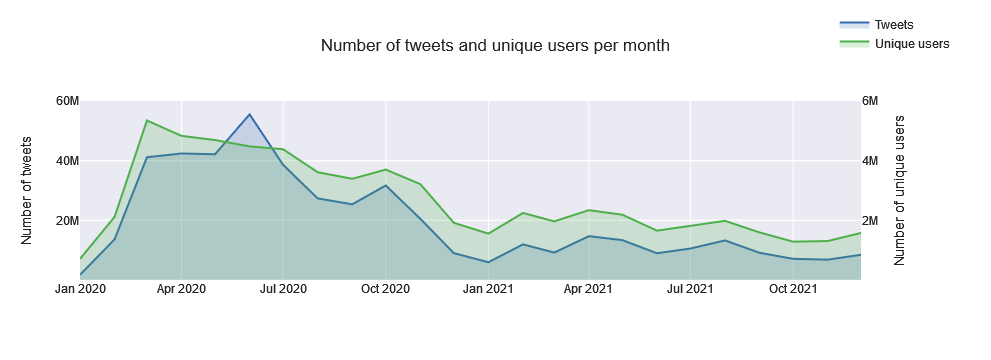

In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=selected.created_at, y=selected.n_tweets, name="Tweets", fill='tozeroy', line=dict(color='rgba(53,108,176,1)'), fillcolor='rgba(53,108,176,0.2)'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=selected.created_at, y=selected.n_unique_users, name="Unique users", fill='tozeroy', line=dict(color='rgba(77,175,74,1)'), fillcolor='rgba(77,175,74,0.2)'),
    secondary_y=True,
)

figy = fig.data[0].y
figy2 = fig.data[1].y
ticksy = list(np.linspace(0, 6e7, endpoint = True, num = 4))[1:]
ticksy2 = list(np.linspace(0, 6e6, endpoint = True, num = 4))[1:]


# fig.update_xaxes(dtick='M1', tickformat="%b", title='Month (2020)')
fig.update_yaxes(range=[0, 6e7], secondary_y=False, title='Number of tweets')
fig.update_yaxes(range=[0,6e6], secondary_y=True, title='Number of unique users')
fig.update_yaxes(tickvals = ticksy, secondary_y=False)
fig.update_yaxes(tickvals = ticksy2, secondary_y=True)
fig.update_layout(template='seaborn', font=dict(family='Helvetica,FreeSans,Arial'), title='Number of tweets and unique users per month', width=800, height=350,
                 legend=dict(yanchor='top', y=1.5, xanchor='right', x=1.05))

fig.show()

In [8]:
fig.write_image('../output/n_tweets_unique_users.pdf')

In [31]:
import plotly.io as pio
pio.templates

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']

In [ ]:
fig = px.area(monthly2020, x='created_at', y=['n_tweets', 'n_unique_users'])
fig.update_traces(stackgroup=None, fill='tozeroy')
fig.show()

In [ ]:
import plotly.express as px

fig = px.area(monthly2020, x='created_at', y=['n_tweets', 'n_unique_users'], title='Number of tweets by month', 
              labels=dict(n_tweets="Tweet count", created_at="Month (2020)"), template='seaborn')
# fig.update_xaxes(nticks=12)
fig.update_xaxes(dtick='M1', tickformat="%b")
fig.update_yaxes(range=[0,60000000], secondary_y=False)
fig.update_yaxes(range=[0,6000000], secondary_y=True)
fig.update_layout(font=dict(family='Helvetica,FreeSans,Arial'))
fig.update_traces(stackgroup=None, fill='tozeroy')
fig.show()

# pd.options.plotting.backend = 'plotly'
# monthly['n_tweets'].plot.bar(title='Number of tweets by month')

In [4]:
fig.write_image('../output/n_tweets_unique_users.pdf')

In [ ]:
monthly2020['n_unique_users'].plot.line(title='Number of unique users by month')

In [6]:
tweets.created_at.dt.date.unique()[0].strftime("%Y-%m-%d")

'2020-06-02'

In [7]:
# Number of tweets
len(tweets['id_str'].unique())

924634
924189


In [ ]:
len(tweets['user.id_str'].unique()